In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [ ]:
def get_pascal_img():
    !unzip '/content/drive/My Drive/PascalVOC2012/PascalVOC2012.zip' -d '/pascalimg/'
get_pascal_img()

Streaming output truncated to the last 5000 lines.
  inflating: /pascalimg/voc2012/VOC2012/SegmentationClass/2008_001829.png  
  inflating: /pascalimg/voc2012/VOC2012/SegmentationClass/2008_001874.png  
  inflating: /pascalimg/voc2012/VOC2012/SegmentationClass/2008_001876.png  
  inflating: /pascalimg/voc2012/VOC2012/SegmentationClass/2008_001882.png  
  inflating: /pascalimg/voc2012/VOC2012/SegmentationClass/2008_001885.png  
  inflating: /pascalimg/voc2012/VOC2012/SegmentationClass/2008_001895.png  
  inflating: /pascalimg/voc2012/VOC2012/SegmentationClass/2008_001896.png  
  inflating: /pascalimg/voc2012/VOC2012/SegmentationClass/2008_001926.png  
  inflating: /pascalimg/voc2012/VOC2012/SegmentationClass/2008_001966.png  
  inflating: /pascalimg/voc2012/VOC2012/SegmentationClass/2008_001971.png  
  inflating: /pascalimg/voc2012/VOC2012/SegmentationClass/2008_001992.png  
  inflating: /pascalimg/voc2012/VOC2012/SegmentationClass/2008_001997.png  
  inflating: /pascalimg/voc2012/VOC20

In [ ]:
!ls /pascalimg/VOC2012/JPEGImages/ | wc -l

17125


In [ ]:
import skimage.io
import skimage.filters

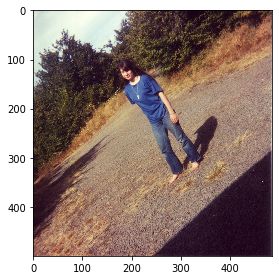

In [ ]:
image = skimage.io.imread(fname='/pascalimg/VOC2012/JPEGImages/2007_000027.jpg')
skimage.io.imshow(image)

In [ ]:
!mkdir /distorted_img/

mkdir: cannot create directory ‘/distorted_img/’: File exists


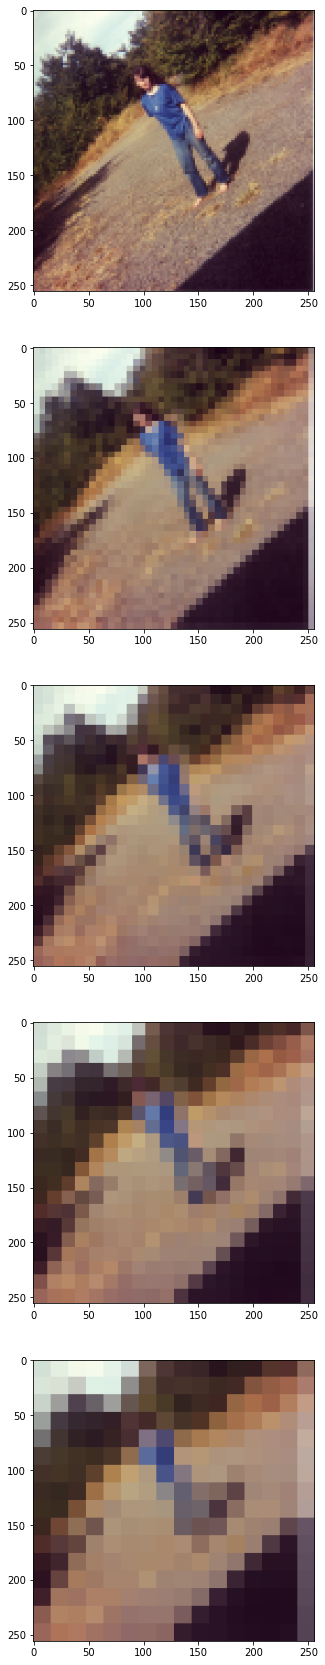

In [ ]:
# from random import randrange
# import sys
# from PIL import Image
# import PIL
# import numpy
# jp2k_level = [4,11,18,25,32]
# fig, axs = plt.subplots(5, 1, figsize=(30,30))
# for i in range(5):
#     image = skimage.io.imread(fname='/pascalimg/VOC2012/JPEGImages/2007_000027.jpg')
#     distorted_path = '/distorted_img/'
#     tmp_name = str(randrange(200000000)) + '.jp2'
#     tmp_path = os.path.join(distorted_path, tmp_name)
#     im = PIL.Image.fromarray(image)
#     im.save(tmp_path,"JPEG2000")
#     distorted_img = np.asanyarray(Image.open(tmp_path).reduce(jp2k_level[i]))
#     distortion_img = tf.image.resize(distorted_img, [256, 256], method='nearest').numpy()
#     axs[i].imshow(distortion_img)
#     # skimage.io.imshow(distorted_img)

In [ ]:
from random import randrange
import sys
from PIL import Image
import PIL
import numpy as np
import cv2
import tensorflow as tf
distorted_path = '/distorted_img/'
def distortion_generator(image, dist_type, level):
    gblur_level = [7,15,39,91,199]
    wn_level = [0,1,2,3,4]
    jpeg_level = [43,12,7,4,0]
    jp2k_level = [4,11,18,25,32]
    pink_level = [0.3,0.7,1.2,2,4]
    dither_level = [64,32,16,8,4]
    dark_level = [1.5,3,4.5,6,7.5]
    bright_level = [1.5,3,4.5,6,7.5]
    if dist_type == 0:
        '''
        Gaussian blur
        '''
        hsize = gblur_level[level]
        distorted_img = cv2.GaussianBlur(image,(hsize,hsize),cv2.BORDER_DEFAULT)

    elif dist_type == 1:
        '''
        Gaussian Noise
        '''
        row,col,ch= image.shape
        mean = 0
        sigma = 2**(wn_level[level]*0.5)
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        distorted_img = image + gauss
    
    elif dist_type == 2:
        '''
        jpeg compression
        '''
        tmp_name = str(randrange(200000000)) + '.jpg'
        tmp_path = os.path.join(distorted_path, tmp_name)
        im = PIL.Image.fromarray(image)
        im.save(tmp_path,"JPEG", quality=jpeg_level[level])
        distorted_img = np.asanyarray(Image.open(tmp_path))

    elif dist_type == 3:
        '''
        Jpeg 2000 compression
        '''
        tmp_name = str(randrange(200000000)) + '.jp2'
        tmp_path = os.path.join(distorted_path, tmp_name)
        im = PIL.Image.fromarray(image)
        im.save(tmp_path,"JPEG2000")
        distorted_img = np.asanyarray(Image.open(tmp_path).reduce(jp2k_level[level]))

    elif dist_type == 4:
        '''
        contrast stretching
        '''
        x_min = [0.2, 0.3, 0.4, 0.45, 0.49]
        x_max = [0.8, 0.7, 0.6, 0.55, 0.51]
        gamma = 1
        a = image.min()
        b = image.max()
        c = x_min[level] * 255
        d = x_max[level] * 255
        y = (((image - a) / (b - a)) ** gamma) * (d - c) + c
        distorted_img = y
    
    elif dist_type == 5:
        '''
        motion blur
        '''
        kernel_size = 30
        kernel = np.zeros((kernel_size, kernel_size))
        if level == 0:
            kernel[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
        elif level == 1:
            kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
        kernel /= kernel_size
        distorted_img = cv2.filter2D(image, -1, kernel)
    return distorted_img.astype('uint8')

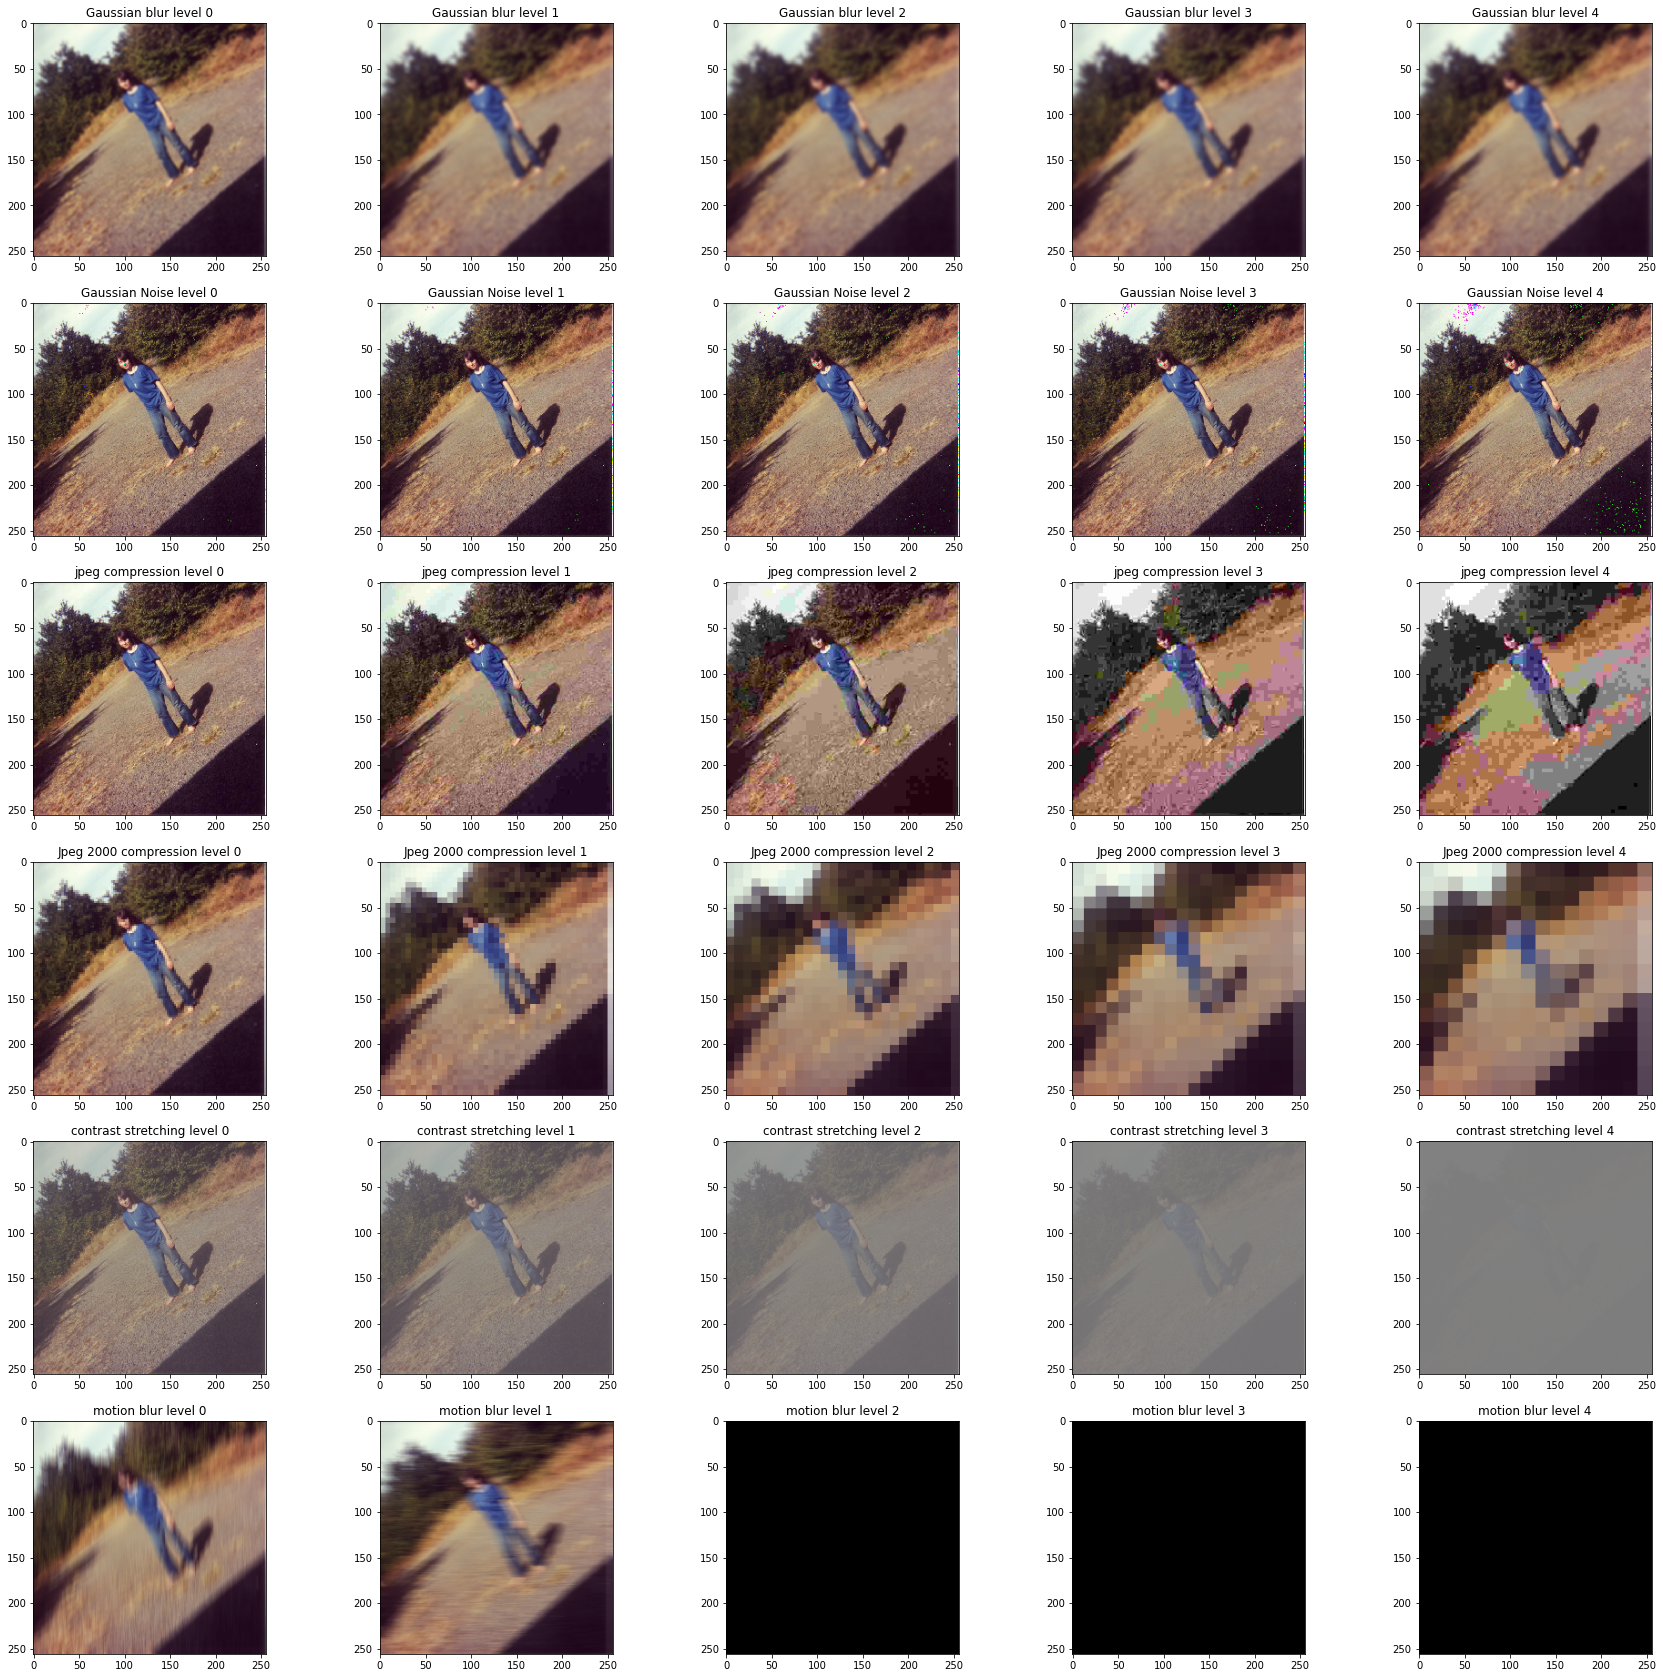

In [ ]:
from matplotlib.pyplot import figure
fig, axs = plt.subplots(6, 5, figsize=(30,30))
dist_name = ['Gaussian blur', 'Gaussian Noise', 'jpeg compression', 'Jpeg 2000 compression','contrast stretching', 'motion blur']
for i in range(6):
    for j in range(5):
      distortion_img = distortion_generator(image, i, j)
      distortion_img = tf.image.resize(distortion_img, [256, 256], method='nearest').numpy()
      axs[i,j].title.set_text(dist_name[i]+' level '+str(j))
      axs[i,j].imshow(distortion_img)

In [ ]:
path = '/pascalimg/VOC2012/JPEGImages/'
files = os.listdir(path)
img_name_list = []
for f in files:
    img_name_list.append(f)
len(img_name_list)

17125

In [ ]:
!mkdir /all_img/
!mkdir /all_img/train/
!mkdir /all_img/test/
for i in range(27):
    !mkdir /all_img/test/{i}
    !mkdir /all_img/train/{i}

In [ ]:
image_class = {}
import random
import matplotlib
for idx, img_name in enumerate(img_name_list):   
    if idx % 200 == 0:
        print(idx)
    used_set = set()
    image_name = img_name[:-4]
    image_np_path = '/all_img/train/'
    image_numpy = skimage.io.imread(path + img_name)
    while len(used_set) <= 18:
        rand_dist = random.randint(0, 26)
        dist_type = rand_dist // 5
        level = rand_dist % 5
        if (dist_type, level) not in used_set:
            image_name_tmp = image_name + 'D' + str(dist_type) + 'L' + str(level) + '.jpeg'
            image_class[image_name_tmp] = rand_dist
            used_set.add((dist_type, level))
            distortion_img = distortion_generator(image_numpy, dist_type, level)
            distortion_img = tf.image.resize(distortion_img, [256, 256], method='nearest').numpy()
            matplotlib.image.imsave(image_np_path+str(rand_dist)+'/'+image_name_tmp, distortion_img)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600
16800
17000


In [ ]:
for i in range(27):
    path_train = '/all_img/train/'
    path_test = '/all_img/test/'
    move_path_train = os.path.join(path_train, str(i))
    move_path_test = os.path.join(path_test, str(i))
    files = os.listdir(move_path_train)
    move_img_list = random.sample(files, int(len(files)*0.2))
    for move_img in move_img_list:
        img_path = os.path.join(move_path_train, move_img)
        !mv {img_path} {move_path_test}

In [ ]:
from google.colab import files
!zip -r '/content/drive/My Drive/Image_data/img_data2.zip' /all_img/

Streaming output truncated to the last 5000 lines.
  adding: all_img/train/15/2011_002756D3L0.jpeg (deflated 2%)
  adding: all_img/train/15/2009_000727D3L0.jpeg (deflated 1%)
  adding: all_img/train/15/2012_000980D3L0.jpeg (deflated 1%)
  adding: all_img/train/15/2008_001729D3L0.jpeg (deflated 3%)
  adding: all_img/train/15/2012_002758D3L0.jpeg (deflated 3%)
  adding: all_img/train/15/2012_001320D3L0.jpeg (deflated 1%)
  adding: all_img/train/15/2007_005114D3L0.jpeg (deflated 1%)
  adding: all_img/train/15/2011_000222D3L0.jpeg (deflated 1%)
  adding: all_img/train/15/2008_000009D3L0.jpeg (deflated 1%)
  adding: all_img/train/15/2008_005926D3L0.jpeg (deflated 2%)
  adding: all_img/train/15/2010_005432D3L0.jpeg (deflated 1%)
  adding: all_img/train/15/2009_002193D3L0.jpeg (deflated 1%)
  adding: all_img/train/15/2011_000502D3L0.jpeg (deflated 2%)
  adding: all_img/train/15/2011_005614D3L0.jpeg (deflated 2%)
  adding: all_img/train/15/2007_004190D3L0.jpeg (deflated 3%)
  adding: all_img/t